In [1]:
#This notebook imports data from ATS model output and plots flow from individual Hydrogeomorphic features across a watershed
#Ashleigh Kirker modified 4/2/2025

#Make the figures appear in this notbook and not in a pop-up
%matplotlib inline


#Import packages for plotting and data analysis
import sys,os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
import scipy.stats
import pandas
from datetime import datetime, date, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.gridspec import SubplotSpec
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression

#We are using these Color Blind Safe Category Colors
#1b9e77 - Wetland
#d95f02 - Incised
#7570b3 - Typical

In [2]:
directory = "~/OneDrive - Virginia Tech/ATS Paper/Raw Data"

In [3]:
#Load HGF and catchment sizes sizes in square meters for converting from volumes to depths

#HGF Polygons
southInc_size = 19991.60
southTyp_size = 9623.86
southWet_size = 16750.85

largeInc_size = 26123.42
largeWet_size = 26366.83
largeTyp_size = 7875.23

northTyp1_size = 12847.40
northTyp2_size = 5721.51
northWet_size = 11914.59

#Catchments based on HGF outlets
southInc_catch = 99086.12
southTyp_catch = 24130.34
southWet_catch = 84061.31

largeInc_catch = 86068.48
largeWet_catch = 95416.16
largeTyp_catch = 101036.64

northTyp1_catch = 42818.91
northWet_catch = 31359.57
northTyp2_catch = 44139.48


#Full Watersheds - the South Watershed is "Moderately Incised", the Large Watershed is "Most Incised" and the North Watershed is "Least Incised"
southWat_size = 226081
largeWat_size = 300065
northWat_size = 130774

#aimsWat size 
aimsWat_size = 533055

In [4]:
#Load South Watershed Data from the .dat file output by ATS
southOutput = pandas.read_csv(os.path.join(directory, 'southHGUs.dat'), comment='#').iloc[36:]

#We need the time column
south_times = southOutput["time [s]"][:]

#Get Water Table Depths for each HGF
southIncised_depth = -southOutput["South Incised Reach Depth to Water [m]"][:]
southTyp_depth = -southOutput["South Typical Reach Depth to Water [m]"][:]
southWet_depth = -southOutput["South Wet Reach Depth to Water [m] "][:]

#Get Outflow from each HGF and convert from mol/h to m3/hr. Fix the Sign if needed
southInc_out = southOutput["South Incised Reach Outflow [mol/h]"][:]/(55600.)
southTyp_out = southOutput["South Typical Reach Outflow [mol/h]"][:]/(-55600.)
southWet_out = southOutput["South Wet Reach Outflow [mol/h]"][:]/(-55600.)

In [5]:
#Load North Watershed Data from the .dat file output by ATS
northOutput = pandas.read_csv(os.path.join(directory, 'northHGUs.dat'), comment='#').iloc[36:]

#We need the time column
north_times = northOutput["time [s]"][:]

#Get Water Table Depths for each HGF
northTyp1_depth = -northOutput["North Typical1 Reach Depth to Water [m]"][:]
northTyp2_depth = -northOutput["North Typical2 Reach Depth to Water [m]"][:]
northWet_depth = -northOutput["North Wet Reach Depth to Water [m] "][:]

#Get Outflow from each HGF and convert from mol/h to m3/hr. Fix the Sign if needed
northTyp1_out = northOutput["North Typical1 Reach Outflow [mol/h]"][:]/(55600.)
northTyp2_out = northOutput["North Typical2 Reach Outflow [mol/h]"][:]/(-55600.)
northWet_out = northOutput["North Wet Reach Outflow [mol/h]"][:]/(-55600.)


In [6]:
#Load Large Watershed Data from the .dat file output by ATS
largeOutput = pandas.read_csv(os.path.join(directory, 'centralHGUs.dat'), comment='#').iloc[36:]

#We need the time column
large_times = largeOutput["time [s]"][:]

#Get Water Table Depths for each HGF
largeIncised1_depth = -largeOutput["Central Incised1 Reach Depth to Water [m]"][:]
largeTyp_depth = -largeOutput["Central Typical Reach Depth to Water [m]"][:]
largeWet_depth = -largeOutput["Central Wet Reach Depth to Water [m] "][:]

#Get Outflow from each HGF and convert from mol/h to m3/hr. Fix the Sign if needed
largeInc_out = largeOutput["Central Incised1 Reach Outflow [mol/h]"][:]/(-55600.)
largeTyp_out = largeOutput["Central Typical Reach Outflow [mol/h]"][:]/(-55600.)
largeWet_out = largeOutput["Central Wet Reach Outflow [mol/h]"][:]/(55600.)

#aimsOut = largeOutput["AIMS Watershed Outflow [mol/h]"]/(-55600.)
#tot_genDepth = (aimsOut/aimsWat_size)*1000

In [7]:
#Convert Outflows to Daily Sums. This simplifies the plots and also makes it easier to compare outflows
#from upstream and downstream HGFs without dealing with time lag

#The model sets time zero to Jan 1, 2016 at midnight
start = datetime.strptime('2016-01-01 00:00:00','%Y-%m-%d %H:%M:%S')
#We need to make this into a timestamp to convert the time column of our data from seconds into python's datetime format
ts = datetime.timestamp(start)

#We can make a datetime list by adding the number of seconds in each row of the .dat file's time column to the timestamp we generated above
reslist = []
for sec in south_times:
    res_date = ts + sec
    res = datetime.fromtimestamp(res_date)
    reslist.append(res)

#Turn the HGF's outflow from a series into a pandas dataframe so we can manipulate it
southIncised_out_daily = pandas.DataFrame(southInc_out)
#Add the datetimes as a column in the dataframe
southIncised_out_daily["DateTime"] = reslist
#Then make that column into an index
southIncised_out_daily = southIncised_out_daily.set_index('DateTime')
#Sum HGF outflow across an entire day, so that we are reporting outflow in cubic meters per day
southIncised_out_daily = southIncised_out_daily.resample('D').sum()
southIncised_out_daily = southIncised_out_daily.rename(columns={0:"Runoff [m3]"})
#And trim the data to our study period of interest - we don't want to include the model spin-up period
southIncised_out_daily = southIncised_out_daily.loc['2017-02-27':'2018-01-10']

southTyp_out_daily = pandas.DataFrame(southTyp_out)
southTyp_out_daily["DateTime"] = reslist
southTyp_out_daily = southTyp_out_daily.set_index('DateTime')
southTyp_out_daily = southTyp_out_daily.resample('D').sum()
southTyp_out_daily = southTyp_out_daily.rename(columns={0:"Runoff [m3]"})
southTyp_out_daily = southTyp_out_daily.loc['2017-02-27':'2018-01-10']

southWet_out_daily = pandas.DataFrame(southWet_out)
southWet_out_daily["DateTime"] = reslist
southWet_out_daily = southWet_out_daily.set_index('DateTime')
southWet_out_daily = southWet_out_daily.resample('D').sum()
southWet_out_daily = southWet_out_daily.rename(columns={"South Wet Reach Outflow [mol/h]":"Runoff [m3]"})
southWet_out_daily = southWet_out_daily.loc['2017-02-27':'2018-01-10']

      
largeIncised1_out_daily = pandas.DataFrame(largeInc_out)
largeIncised1_out_daily["DateTime"] = reslist
largeIncised1_out_daily = largeIncised1_out_daily.set_index('DateTime')
largeIncised1_out_daily = largeIncised1_out_daily.resample('D').sum()
largeIncised1_out_daily = largeIncised1_out_daily.rename(columns={0:"Runoff [m3]"})
largeIncised1_out_daily = largeIncised1_out_daily.loc['2017-02-27':'2018-01-10']

largeTyp_out_daily = pandas.DataFrame(largeTyp_out)
largeTyp_out_daily["DateTime"] = reslist
largeTyp_out_daily = largeTyp_out_daily.set_index('DateTime')
largeTyp_out_daily = largeTyp_out_daily.resample('D').sum()
largeTyp_out_daily = largeTyp_out_daily.rename(columns={"Central Typical Reach Outflow [mol/h]":"Runoff [m3]"})
largeTyp_out_daily = largeTyp_out_daily.loc['2017-02-27':'2018-01-10']

largeWet_out_daily = pandas.DataFrame(largeWet_out)
largeWet_out_daily["DateTime"] = reslist
largeWet_out_daily = largeWet_out_daily.set_index('DateTime')
largeWet_out_daily = largeWet_out_daily.resample('D').sum()
largeWet_out_daily = largeWet_out_daily.rename(columns={0:"Runoff [m3]"})
largeWet_out_daily = largeWet_out_daily.loc['2017-02-27':'2018-01-10']

#aims_out_daily = pandas.DataFrame(aimsOut)
#aims_out_daily["DateTime"] = reslist
#aims_out_daily = aims_out_daily.set_index('DateTime')
#aims_out_daily = aims_out_daily.resample('D').sum()
#aims_out_daily = aims_out_daily.rename(columns={"AIMS Watershed Outflow [mol/h]":"Runoff [m3]"})
#aims_out_daily = aims_out_daily.loc['2017-02-27':'2018-01-10']

northTyp1_out_daily = pandas.DataFrame(northTyp1_out)
northTyp1_out_daily["DateTime"] = reslist
northTyp1_out_daily = northTyp1_out_daily.set_index('DateTime')
northTyp1_out_daily = northTyp1_out_daily.resample('D').sum()
northTyp1_out_daily = northTyp1_out_daily.rename(columns={0:"Runoff [m3]"})
northTyp1_out_daily = northTyp1_out_daily.loc['2017-02-27':'2018-01-10']

northTyp2_out_daily = pandas.DataFrame(northTyp2_out)
northTyp2_out_daily["DateTime"] = reslist
northTyp2_out_daily = northTyp2_out_daily.set_index('DateTime')
northTyp2_out_daily = northTyp2_out_daily.resample('D').sum()
northTyp2_out_daily = northTyp2_out_daily.rename(columns={"North Typical2 Reach Outflow [mol/h]":"Runoff [m3]"})
northTyp2_out_daily = northTyp2_out_daily.loc['2017-02-27':'2018-01-10']

northWet_out_daily = pandas.DataFrame(northWet_out)
northWet_out_daily["DateTime"] = reslist
northWet_out_daily = northWet_out_daily.set_index('DateTime')
northWet_out_daily = northWet_out_daily.resample('D').sum()
northWet_out_daily = northWet_out_daily.rename(columns={0:"Runoff [m3]"})
northWet_out_daily = northWet_out_daily.loc['2017-02-27':'2018-01-10']



In [8]:
#Instead of reporting total outflow at each HGF, it is more useful to report the flow *generated* in each HGF
#which we can calculate by subtracting the daily flow into HGF from the daily flow out of it. 
#For headwater HGFs where the stream originates, inflow is zero

northTyp2_flowgen_daily = northTyp2_out_daily.iloc[:,0]
northWet_flowgen_daily = northWet_out_daily.iloc[:,0] - northTyp2_out_daily.iloc[:,0]
northTyp1_flowgen_daily = northTyp1_out_daily.iloc[:,0] - northWet_out_daily.iloc[:,0]

largeTyp_flowgen_daily = largeTyp_out_daily.iloc[:,0]
largeWet_flowgen_daily = largeWet_out_daily.iloc[:,0] - largeTyp_out_daily.iloc[:,0]
largeIncised1_flowgen_daily = largeIncised1_out_daily.iloc[:,0] - largeWet_out_daily.iloc[:,0]

southWet_flowgen_daily = southWet_out_daily.iloc[:,0]
southIncised_flowgen_daily = southIncised_out_daily.iloc[:,0] - southTyp_out_daily.iloc[:,0]
southTyp_flowgen_daily = southTyp_out_daily.iloc[:,0] - southWet_out_daily.iloc[:,0]

#The total flow generated in all of our subwatersheds is the sum of the flow leaving each subwatershed
tot_flow_daily =  largeIncised1_out_daily.iloc[:,0] + southIncised_out_daily.iloc[:,0] +  northTyp1_out_daily.iloc[:,0]

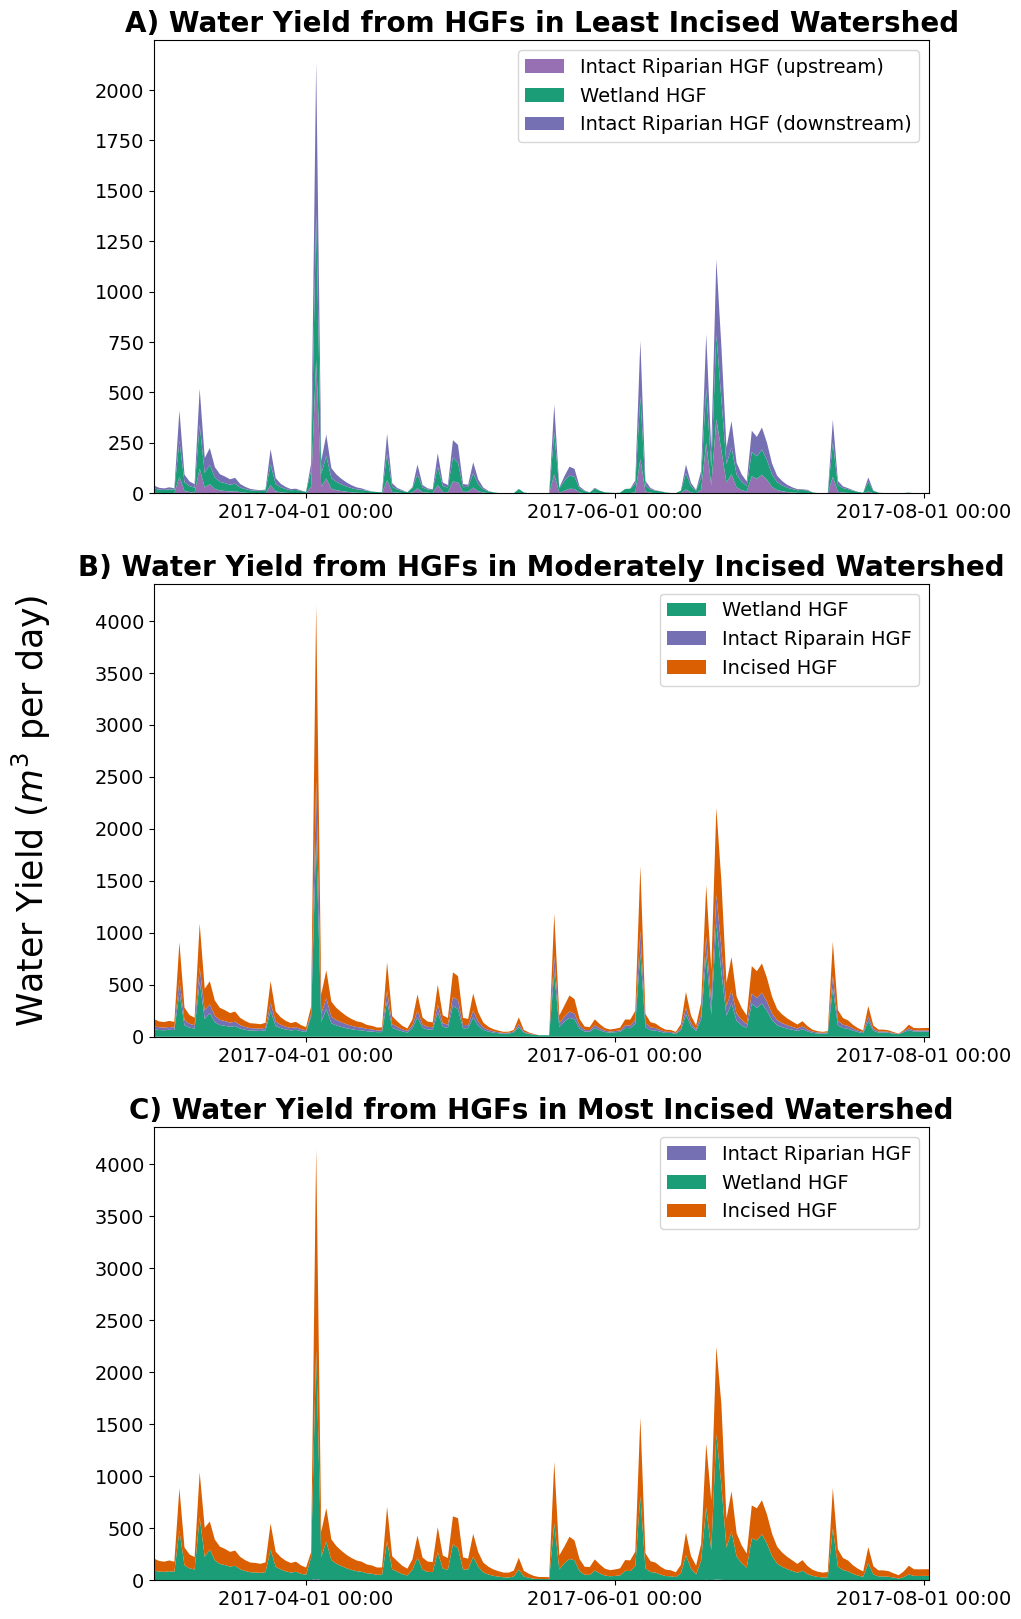

In [9]:
#This figure will plot flow generated in each HGF for each of three subwatersheds

#Figure 3.  Plot showing daily proportions of flow at outlet.

fig, ax = plt.subplots(3,1, figsize=(10, 20))

#stacked area plots are weird, they show negative values as positive, so we need to replace negative values with 0
northTyp2_flow_daily = northTyp2_flowgen_daily.clip(0)
northWet_flow_daily = northWet_flowgen_daily.clip(0)
northTyp1_flow_daily = northTyp1_flowgen_daily.clip(0)
southWet_flow_daily = southWet_flowgen_daily.clip(0)
southTyp_flow_daily = southTyp_flowgen_daily.clip(0)
southIncised_flow_daily = southIncised_flowgen_daily.clip(0)
largeTyp_flow_daily = largeTyp_flowgen_daily.clip(0)
largeWet_flow_daily = largeWet_flowgen_daily.clip(0)
largeIncised1_flow_daily = largeIncised1_flowgen_daily.clip(0)


#Plot the North (least Incised) Watershed 

ax[0].stackplot(northTyp2_flow_daily.index,  northTyp2_flow_daily, northWet_flow_daily, northTyp1_flow_daily, labels = ['Intact Riparian HGF (upstream)', 'Wetland HGF', 'Intact Riparian HGF (downstream)'], 
                 colors=['#9770b3','#1b9e77', '#7570b3'], linewidth=0.001)
ax[0].set_title("A) Water Yield from HGFs in Least Incised Watershed", fontsize=20, fontweight="bold")
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#ax[0].set_ylabel('Discharge from HGF [$m^3$ per day]', fontsize=25)    
ax[0].set(xlim=(17227,17380))
#ax[0].set(ylim=(0,20))
ax[0].legend(loc="upper right", fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)


#Plot the South (Moderately Incised) Watershed 

ax[1].stackplot(southWet_flow_daily.index, southWet_flow_daily, southTyp_flow_daily,southIncised_flow_daily, labels = ['Wetland HGF','Intact Riparain HGF', 'Incised HGF'],
              colors=['#1b9e77','#7570b3', '#d95f02'], linewidth=0.001)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[1].set_ylabel('Water Yield ($m^3$ per day)', fontsize=25, labelpad=30) 
ax[1].set_title("B) Water Yield from HGFs in Moderately Incised Watershed", fontsize=20, fontweight="bold")
ax[1].set(xlim=(17227,17380))
#ax[1].set(ylim=(0,20))
ax[1].legend(loc="upper right", fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

#Plot the Large (Most Incised) Watershed 

ax[2].stackplot(northTyp2_flow_daily.index, largeTyp_flow_daily, largeWet_flow_daily, largeIncised1_flow_daily, 
                 labels = ['Intact Riparian HGF', 'Wetland HGF', 'Incised HGF'], colors=['#7570b3','#1b9e77','#d95f02'], linewidth=0.001)
ax[2].set_title("C) Water Yield from HGFs in Most Incised Watershed", fontsize = 20, fontweight="bold")
ax[2].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#ax[2].set_ylabel('Discharge from HGF [$m^3$ per day]', fontsize=25)   
ax[2].set(xlim=(17227,17380))
#ax[2].set(ylim=(0,20))
ax[2].legend(loc="upper right", fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)

#Add some space in between subplots
plt.subplots_adjust(wspace=2)

fig

In [10]:
#Save all the flowgen values (negatives included) to a csv file so that we can generate donut plots in excel
df = pandas.concat([northTyp2_flowgen_daily,northWet_flowgen_daily,northTyp1_flowgen_daily, southWet_flowgen_daily, southTyp_flowgen_daily, southIncised_flowgen_daily, largeTyp_flowgen_daily, largeWet_flowgen_daily, largeIncised1_flowgen_daily],axis=1)
df.to_csv('daily_flowgen_v2.csv', sep=',')

In [11]:
#The next portion of the code will generate a Cumulative Distribution Function Plot which aggregates data from each category of HGF
#across all subwatersheds and compares it to total outflow

#sum up generated flow from HGFs of the same category
wetland_outflow = northWet_flowgen_daily + southWet_flowgen_daily + largeWet_flowgen_daily
incised_outflow = southIncised_flowgen_daily + largeIncised1_flowgen_daily
intact_outflow = northTyp2_flowgen_daily + northTyp1_flowgen_daily + southTyp_flowgen_daily + largeTyp_flowgen_daily


In [12]:
# Sort the data by discharge values
intact_sorted = intact_outflow.sort_values().to_frame()
incised_sorted = incised_outflow.sort_values().to_frame()
wetland_sorted = wetland_outflow.sort_values().to_frame()
tot_sorted = tot_flow_daily.sort_values().to_frame()


In [13]:
# Calculate the cumulative probability
intact_sorted['CDF']= intact_sorted.rank(method='max') / intact_sorted.count()
wetland_sorted['CDF']= wetland_sorted.rank(method='max') / wetland_sorted.count()
incised_sorted['CDF']= incised_sorted.rank(method='max') / incised_sorted.count()
tot_sorted['CDF']= tot_sorted.rank(method='max') / tot_sorted.count()


In [14]:
#We are also interested in how the Stream Length in each HGF type correlates to the amount of Flow generated in each HGF
#So we will import the stream length in each HGF and calculate that HGF's proportion of total streams in the watershed

#This is the length of streams in the watershed in meters
aims_streams = 2749.75

northWet_stream = 199.03
northWet_percentLength = northWet_stream/aims_streams
northTyp1_stream = 181.56
northTyp1_percentLength = northTyp1_stream/aims_streams
northTyp2_stream = 80.34
northTyp2_percentLength = northTyp2_stream/aims_streams

southTyp_stream = 157.77
southTyp_percentLength = southTyp_stream/aims_streams

southInc_stream = 352.80
southInc_percentLength = southInc_stream/aims_streams
print(southInc_percentLength)
southWet_stream = 199.53
southWet_percentLength = southWet_stream/aims_streams
print(southWet_percentLength)

centralInc_stream = 479.20
centralInc_percentLength = centralInc_stream/aims_streams
print(centralInc_percentLength)
centralTyp_stream = 137.38
centralTyp_percentLength = centralTyp_stream/aims_streams
centralWet_stream = 340.71
centralWet_percentLength = centralWet_stream/aims_streams
print(centralWet_percentLength)

#Aggregate by HGF type
allInc_streamLength_per = centralInc_percentLength + southInc_percentLength
allWet_streamLength_per = centralWet_percentLength + southWet_percentLength + northWet_percentLength
allTyp_streamLength_per = centralTyp_percentLength + southTyp_percentLength + northTyp1_percentLength + northTyp2_percentLength

0.12830257296117828
0.07256296026911538
0.17427038821711063
0.12390580961905627


In [15]:
#We will calulate the flow generated in each HGF by summing the values over the study period
#And calculate the proportion of total flow across the watershed generated in each HGF by dividing by the total cumulative outflow
tot_flow = tot_flow_daily.sum()

northWet_tot_flow = northWet_flowgen_daily.sum()
northWet_percentflow = northWet_tot_flow/tot_flow
northTyp1_tot_flow = northTyp1_flowgen_daily.sum()
northTyp1_percentflow = northTyp1_tot_flow/tot_flow
northTyp2_tot_flow = northTyp2_flowgen_daily.sum()
northTyp2_percentflow = northTyp2_tot_flow/tot_flow

southTyp_tot_flow = southTyp_flowgen_daily.sum()
southTyp_percentflow = southTyp_tot_flow/tot_flow
southInc_tot_flow = southIncised_flowgen_daily.sum()
southInc_percentflow = southInc_tot_flow/tot_flow
southWet_tot_flow = southWet_flowgen_daily.sum()
southWet_percentflow = southWet_tot_flow/tot_flow

centralInc_tot_flow = largeIncised1_flowgen_daily.sum()
centralInc_percentflow = centralInc_tot_flow/tot_flow
centralTyp_tot_flow = largeTyp_flowgen_daily.sum()
centralTyp_percentflow = centralTyp_tot_flow/tot_flow
centralWet_tot_flow = largeWet_flowgen_daily.sum()
centralWet_percentflow = centralWet_tot_flow/tot_flow


tot = centralWet_percentflow + centralTyp_percentflow + centralInc_percentflow + southWet_percentflow + southInc_percentflow + southTyp_percentflow + northTyp1_percentflow + northTyp2_percentflow + northWet_percentflow

#Check that the percent is around 100 - a little off is okay
print(tot)

1.0000000000000002


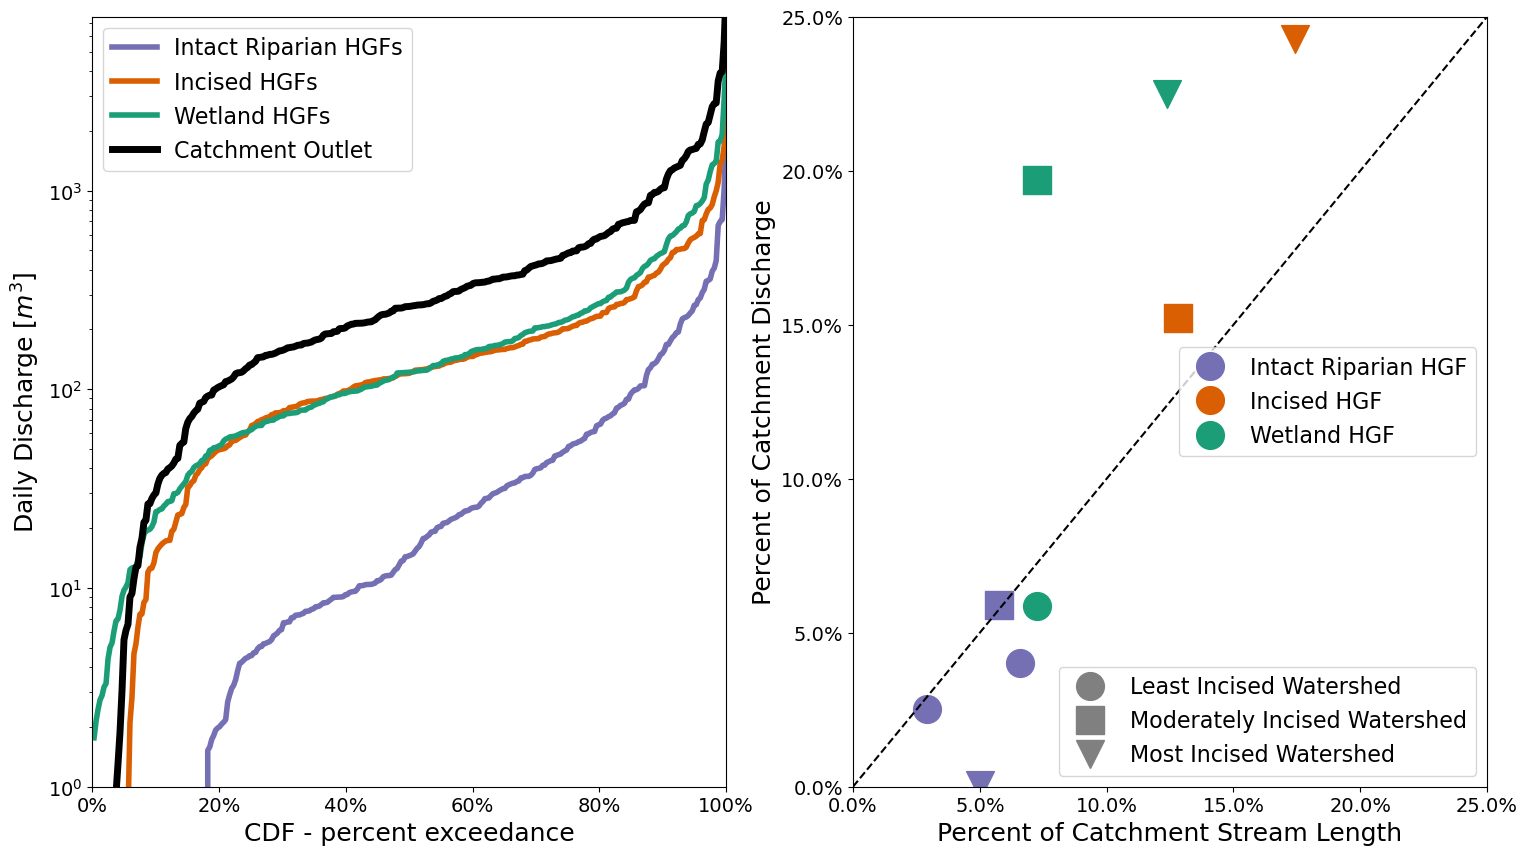

In [16]:
#Make Figure with 2 Subplots
fig, ax = plt.subplots(1,2, figsize=(18, 10))
from matplotlib.lines import Line2D

#Plot the cumulative distribution function on the left
ax[0].plot(intact_sorted['CDF'],intact_sorted[0], lw=4, color='#7570b3', label = "Intact Riparian HGFs")
ax[0].plot(incised_sorted['CDF'], incised_sorted[0], lw=4, color='#d95f02', label = "Incised HGFs")
ax[0].plot(wetland_sorted['CDF'],wetland_sorted[0],  lw=4,color='#1b9e77', label = "Wetland HGFs")
ax[0].plot(tot_sorted['CDF'], tot_sorted[0], lw=5, color='k', label = "Catchment Outlet")
ax[0].set_yscale('log')
ax[0].set(xlim=(0,1))
ax[0].set(ylim=(1,7500))
#Set the X axis to display as percent (for percent exceedence)
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax[0].set_ylabel('Daily Discharge [$m^3$]', fontsize =18)
ax[0].set_xlabel('CDF - percent exceedance', fontsize =18)
ax[0].legend(fontsize = 16)
ax[0].tick_params(axis='both', which='major', labelsize=14)

#And make a scatter plot showing the proportion of flow generated versus the proportion of stream length in each HGF on the right
ax[1].axline(xy1=(0, 0), slope=1, ls='--', color='k')
ax[1].scatter(northTyp1_percentLength, northTyp1_percentflow, color='#7570b3', s=400)
ax[1].scatter(northTyp2_percentLength, northTyp2_percentflow, color='#7570b3', s=400)
ax[1].scatter(northWet_percentLength, northWet_percentflow, color='#1b9e77', s=400)

ax[1].scatter(southTyp_percentLength, southTyp_percentflow, color='#7570b3', s=400, marker = "s")
ax[1].scatter(southInc_percentLength, southInc_percentflow, color='#d95f02', s=400, marker = "s")
ax[1].scatter(southWet_percentLength, southWet_percentflow, color='#1b9e77', s=400, marker = "s")

ax[1].scatter(centralInc_percentLength, centralInc_percentflow, color='#d95f02', s=400, marker ="v")
ax[1].scatter(centralWet_percentLength, centralWet_percentflow, color='#1b9e77', s=400, marker ="v")
ax[1].scatter(centralTyp_percentLength, centralTyp_percentflow, color='#7570b3', s=400, marker ="v")

ax[1].set(xlim=(0,0.25))
ax[1].set(ylim=(0,0.25))
#Display the axes as percents instead of proportions
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax[1].set_ylabel('Percent of Catchment Discharge', fontsize =18)
ax[1].set_xlabel('Percent of Catchment Stream Length', fontsize =18)
ax[1].tick_params(axis='both', which='major', labelsize=14)

# Custom legend elements
color_legend = [
    Line2D([0], [0], marker='o', color='w', label='Intact Riparian HGF', markerfacecolor='#7570b3', markersize=22),
    Line2D([0], [0], marker='o', color='w', label='Incised HGF', markerfacecolor='#d95f02', markersize=22),
    Line2D([0], [0], marker='o', color='w', label='Wetland HGF', markerfacecolor='#1b9e77', markersize=22)
]

shape_legend = [
    Line2D([0], [0], marker='o', color='gray', label='Least Incised Watershed', linestyle='None', markersize=20),
    Line2D([0], [0], marker='s', color='gray', label='Moderately Incised Watershed', linestyle='None', markersize=20),
    Line2D([0], [0], marker='v', color='gray', label='Most Incised Watershed', linestyle='None', markersize=20)
]

# Add the legends
legend1 = ax[1].legend(handles=color_legend , loc='center right', fontsize=16)
legend2 = ax[1].legend(handles=shape_legend, loc='lower right', fontsize=16)

# Add the first legend back (otherwise only the second will show)
ax[1].add_artist(legend1)

fig

In [17]:
#Calculate Percent Contribution from each HGF from each Day
northWet_percentdaily = northWet_flowgen_daily/tot_flow_daily
northTyp1_percentdaily = northTyp1_flowgen_daily/tot_flow_daily
northTyp2_percentdaily = northTyp2_flowgen_daily/tot_flow_daily


southTyp_percentdaily  = southTyp_flowgen_daily/tot_flow_daily
southInc_percentdaily = southIncised_flowgen_daily/tot_flow_daily
southWet_percentdaily = southWet_flowgen_daily/tot_flow_daily


centralInc_percentdaily = largeIncised1_flowgen_daily/tot_flow_daily
centralTyp_percentdaily = largeTyp_flowgen_daily/tot_flow_daily
centralWet_percentdaily = largeWet_flowgen_daily/tot_flow_daily

#Then add percents contributed by each HGF type
allInc_percentdaily = southInc_percentdaily + centralInc_percentdaily
allInc_percentdaily = allInc_percentdaily.clip(0)
allWet_percentdaily = centralWet_percentdaily + southWet_percentdaily + northWet_percentdaily
allWet_percentdaily = allWet_percentdaily.clip(0)
allTyp_percentdaily = northTyp1_percentdaily + northTyp2_percentdaily + centralTyp_percentdaily + southTyp_percentdaily
allTyp_percentdaily = allTyp_percentdaily.clip(0)


In [18]:
#Load data from the percent_flowing csv. This was generated by examining model grid cells within each HGF and classifying them as 'wet' or 'dry'
#We use this %wet  metric to give an idea of the extent of the stream network at 2-day timesteps

percentFlow = pandas.read_csv(os.path.join(directory, 'percent_flowing.csv'), comment='#').iloc[93:251]
percentFlow['Date'] = pandas.to_datetime(percentFlow['Date'])
percentFlow.index = percentFlow['Date']

#Aggregate data by HGF type
percentTyp = percentFlow[['NorthTyp2', 'NorthTyp1','SouthTyp','CentralTyp']]
percentWet = percentFlow[['NorthWet', 'SouthWet', 'CentralWet']]
percentInc = percentFlow[['SouthInc', 'CentralInc']]

#Calculate the average percent wet for each time step for each HGF type
avgperTyp = percentTyp.mean(axis=1)
avgperWet = percentWet.mean(axis=1)
avgperInc = percentInc.mean(axis=1)

print(percentFlow)

            Unnamed: 0       Date  NorthTyp2  NorthWet  NorthTyp1  SouthWet  \
Date                                                                          
2017-02-28          93 2017-02-28       0.75  0.416667   0.333333  0.729730   
2017-03-02          94 2017-03-02       0.75  0.500000   0.433333  0.810811   
2017-03-04          95 2017-03-04       0.75  0.416667   0.433333  0.756757   
2017-03-06          96 2017-03-06       0.75  0.416667   0.333333  0.729730   
2017-03-08          97 2017-03-08       0.75  0.416667   0.333333  0.729730   
...                ...        ...        ...       ...        ...       ...   
2017-12-31         246 2017-12-31       0.00  0.333333   0.300000  0.702703   
2018-01-02         247 2018-01-02       0.00  0.333333   0.300000  0.702703   
2018-01-04         248 2018-01-04       0.00  0.333333   0.266667  0.702703   
2018-01-06         249 2018-01-06       0.00  0.333333   0.266667  0.702703   
2018-01-08         250 2018-01-08       0.00  0.3333

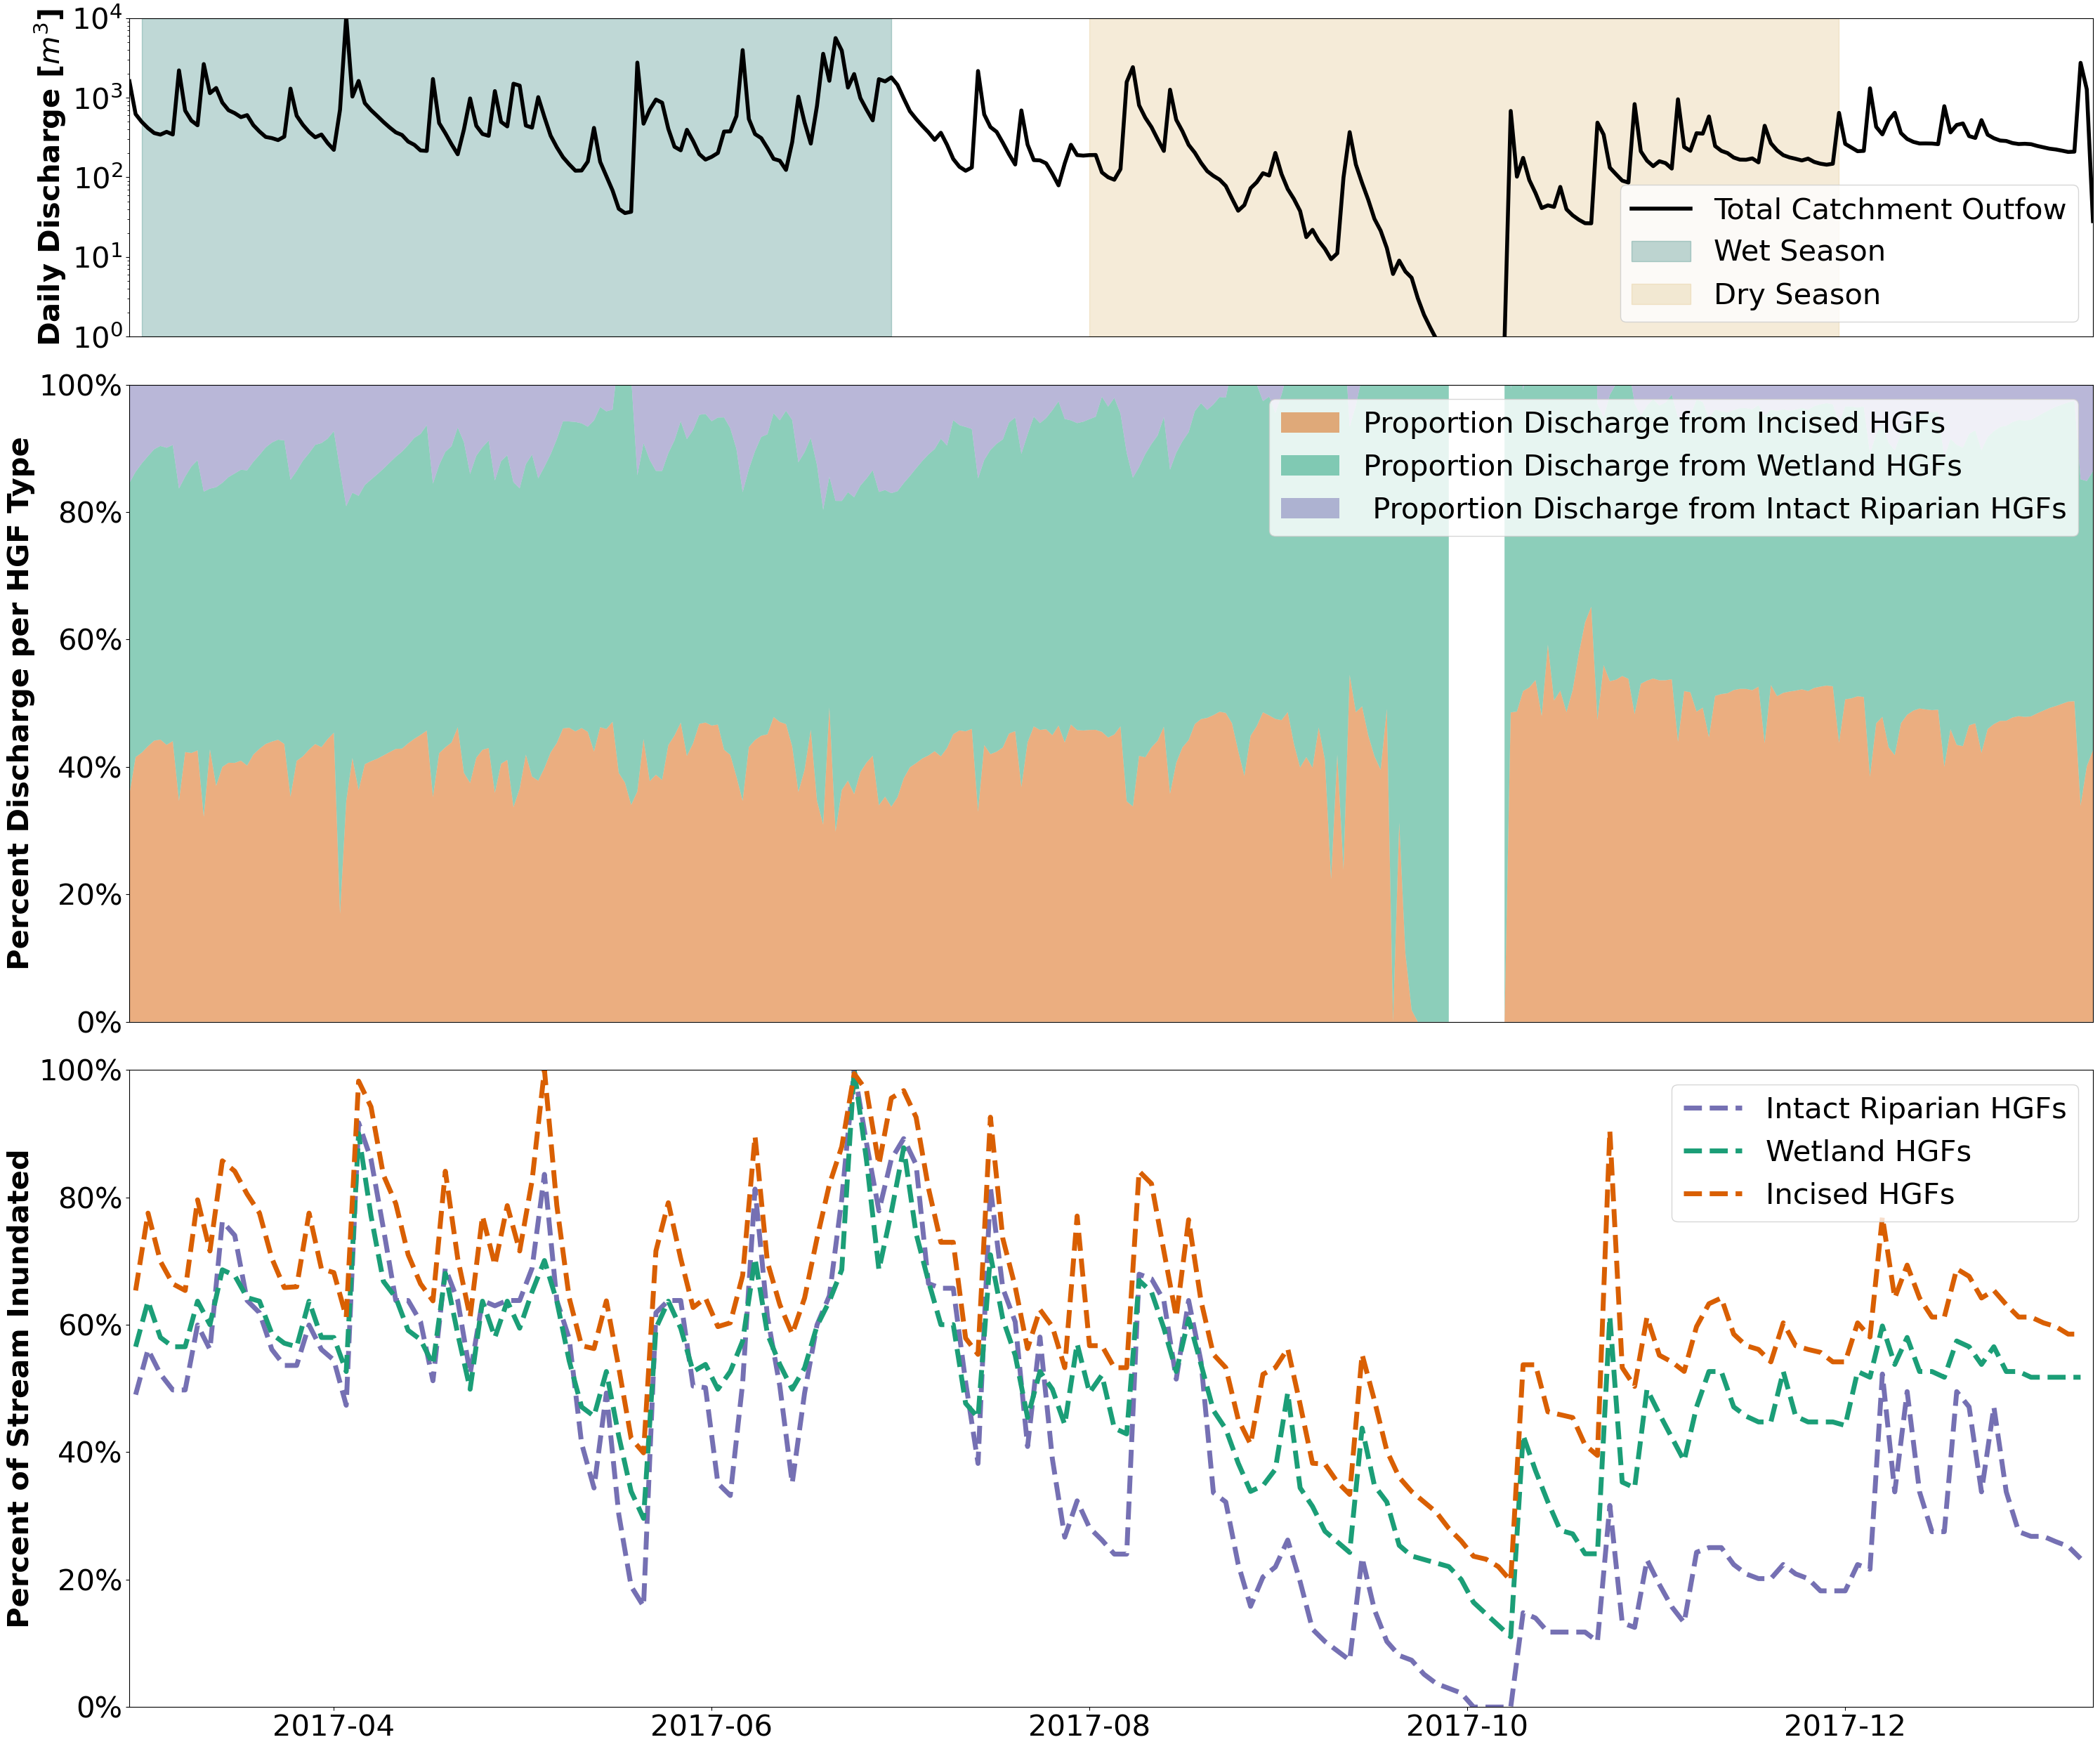

In [19]:
fig, ax = plt.subplots(3,1, figsize=(30, 25), gridspec_kw={'height_ratios': [1, 2, 2]})

import matplotlib.ticker as mtick

#In the top panel, plot total outflow from all three subwatersheds and delineate the dry season and the wet season in beige and blue
ax[0].plot(tot_flow_daily, 'k', linewidth=4, label="Total Catchment Outfow")
ax[0].set(xlim= (datetime.strptime('2017-02-27 00:00:00','%Y-%m-%d %H:%M:%S'), datetime.strptime('2018-01-10 00:00:00','%Y-%m-%d %H:%M:%S')))
ax[0].set_ylabel("Daily Discharge [$m^3$]", fontsize=30, fontweight='bold')
ax[0].axvspan(datetime.strptime('2017-03-01 00:00:00','%Y-%m-%d %H:%M:%S'), datetime.strptime('2017-06-30 00:00:00','%Y-%m-%d %H:%M:%S'), alpha=0.25, color='#01665e', label = "Wet Season")
ax[0].axvspan(datetime.strptime('2017-08-01 00:00:00','%Y-%m-%d %H:%M:%S'), datetime.strptime('2017-11-30 00:00:00','%Y-%m-%d %H:%M:%S'), alpha=0.25, color='#d8b365', label = "Dry Season")
ax[0].get_xaxis().set_visible(False)
ax[0].set(ylim=(1,10000))
ax[0].tick_params(axis='y', which='major', labelsize=30)
ax[0].legend(loc='lower right', fontsize=30)
ax[0].set_yscale('log')

#In the middle panel, plot daily percent flow from each HGF type
ax[1].stackplot(allInc_percentdaily.index, allInc_percentdaily,  allWet_percentdaily, allTyp_percentdaily, 
                 labels = ['Proportion Discharge from Incised HGFs' ,'Proportion Discharge from Wetland HGFs', ' Proportion Discharge from Intact Riparian HGFs' ],colors=['#d95f02',  '#1b9e77', '#7570b3'], alpha = 0.5, linewidth=0.1)
ax[1].set(ylim=(0,1))
ax[1].set(xlim= (datetime.strptime('2017-02-27 00:00:00','%Y-%m-%d %H:%M:%S'), datetime.strptime('2018-01-10 00:00:00','%Y-%m-%d %H:%M:%S')))
ax[1].tick_params(axis='y', which='major', labelsize=30)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax[1].legend(loc='upper right', fontsize=30)
ax[1].set_ylabel("Percent Discharge per HGF Type", fontsize=30, fontweight='bold')
ax[1].get_xaxis().set_visible(False)

#In the bottom panel, plot percent wet at each time step across watersheds, by HGF
ax[2].plot(avgperTyp,color='#7570b3', label="Intact Riparian HGFs", linewidth = 5, ls='--' )
ax[2].plot(avgperWet,color='#1b9e77', label ="Wetland HGFs", linewidth = 5, ls='--' )
ax[2].plot(avgperInc, color='#d95f02', label = "Incised HGFs",linewidth = 5, ls='--' )
ax[2].tick_params(axis='both', which='major', labelsize=30)
ax[2].set(xlim= (datetime.strptime('2017-02-27 00:00:00','%Y-%m-%d %H:%M:%S'), datetime.strptime('2018-01-10 00:00:00','%Y-%m-%d %H:%M:%S')))
ax[2].set_ylabel("Percent of Stream Inundated", fontsize=30, fontweight='bold')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax[2].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[2].legend(loc='upper right', fontsize=30)
ax[2].set(ylim=(0,1))

fig.tight_layout(h_pad=2)
fig

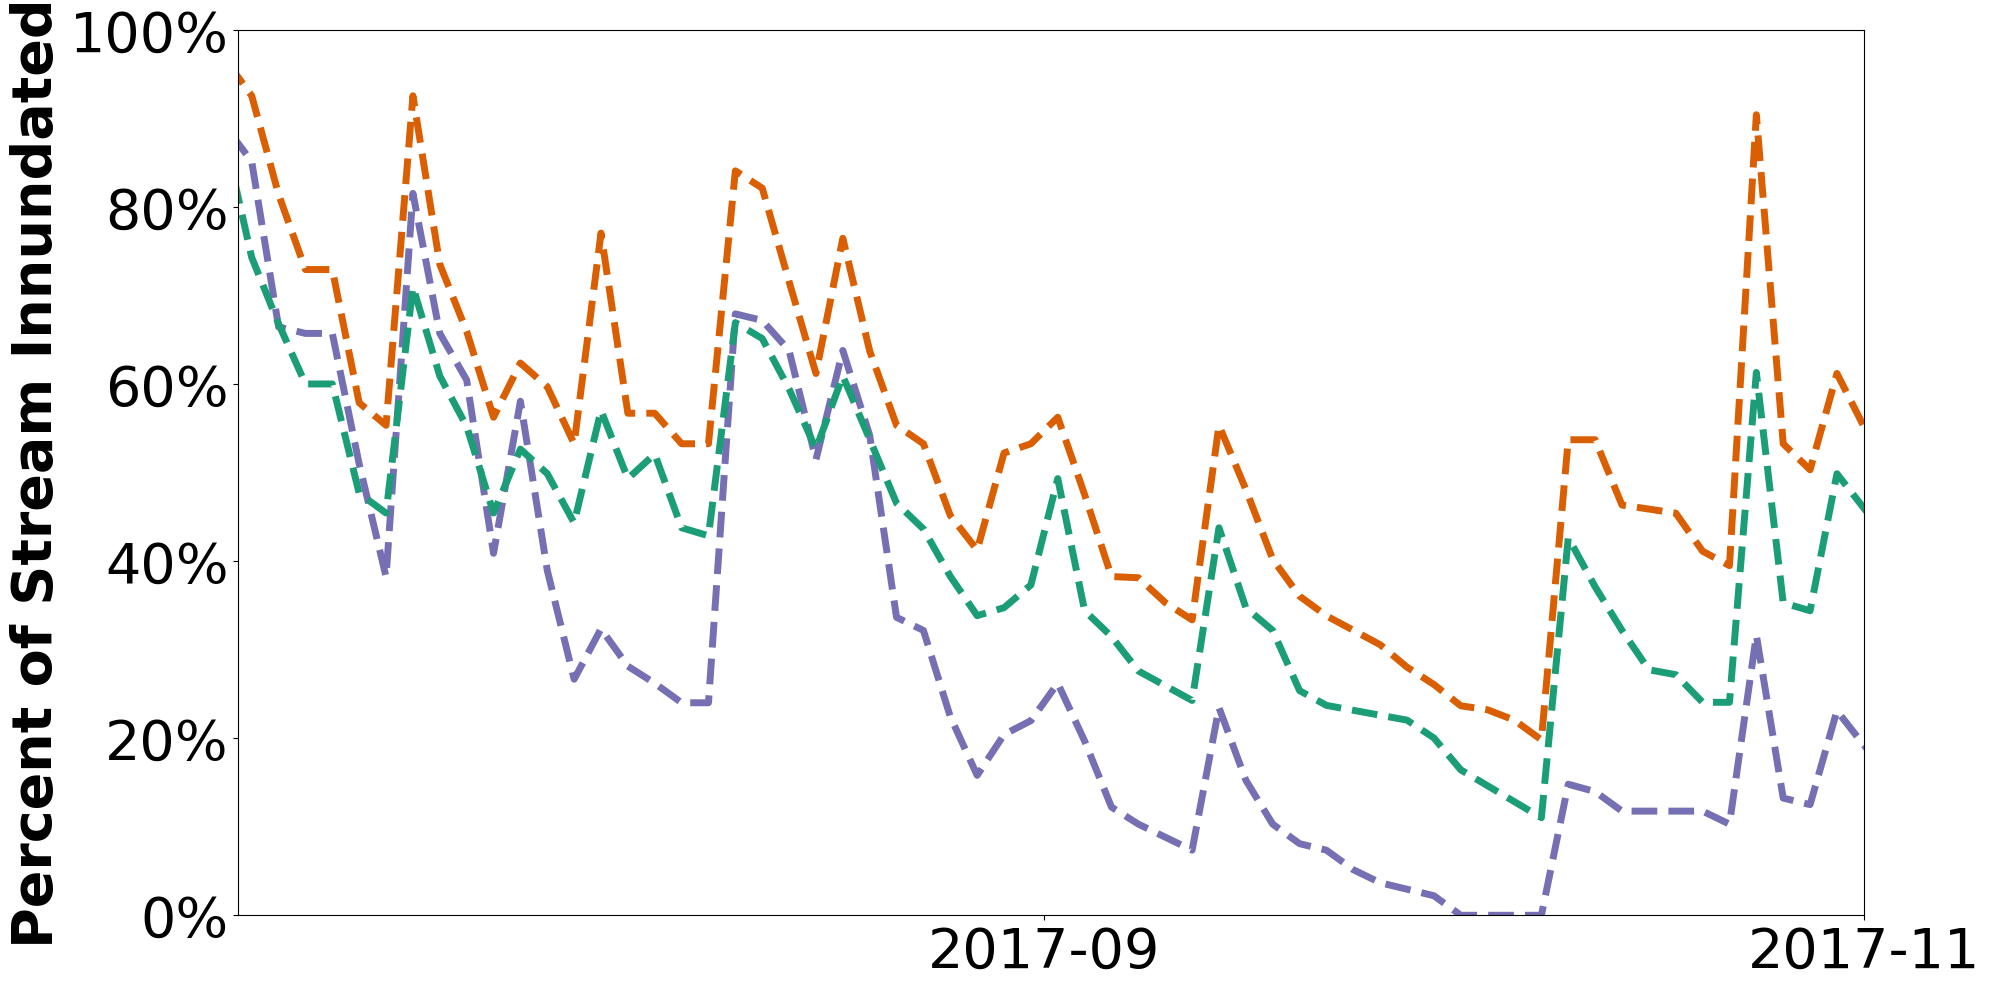

In [20]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

#In the bottom panel, plot percent wet at each time step across watersheds, by HGF
ax.plot(avgperTyp,color='#7570b3', label="Intact Riparian HGFs", linewidth = 5, ls='--' )
ax.plot(avgperWet,color='#1b9e77', label ="Wetland HGFs", linewidth = 5, ls='--' )
ax.plot(avgperInc, color='#d95f02', label = "Incised HGFs",linewidth = 5, ls='--' )
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set(xlim= (datetime.strptime('2017-07-03 00:00:00','%Y-%m-%d %H:%M:%S'), datetime.strptime('2017-11-01 00:00:00','%Y-%m-%d %H:%M:%S')))
ax.set_ylabel("Percent of Stream Innundated", fontsize=40, fontweight='bold')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax.legend(loc='upper right', fontsize=30)
ax.set(ylim=(0,1))

fig.tight_layout(h_pad=2)
fig